# Laboration Deep learning 
### 
I den här labben kommer du få jobba med bildbehandling, filhantering, bygga upp egna tränings, validerings
och testdataset från en mängd av bilder. Vidare får du jobba med begränsade datamängder för att efterlikna
verkligheten när dataanskaffning är en oerhört dyr process. Efter databehandlingen och databearbetningen
kommer du få pröva olika slags convolutional neural networks tränade från scratch och slutligen använda
dig av transfer learning för att återanvända nätverk skapade av toppforskare inom computer vision.

In [163]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from pathlib import Path

## b) Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.

In [164]:
# Checking my data position
Path().absolute() / "original_data"

WindowsPath('c:/CODING/Github/Python-AI-Sandra-OPA23/Lab_2/original_data')

In [165]:
#Creating a funtion to open the images 
def read_images (folder_path):
    current_Path = Path().absolute()
    print(f"{current_Path = }")
    data_path = current_Path / "original_data" / "train" / "train"
    print(f"{data_path = }")
    #
    images = []
    image_paths = []
    for i in range(1, 11): #läser 10 bilder 
        image_file = data_path / f"cat.{i}.jpg"
      
        image = cv2.imread(str(image_file))
        if image is not None:
            images.append(image)
            image_paths.append(str(image_file))

    return images, image_paths



# min sökväg
folder_path = Path( "original_data") / "train" / "train"

# Läs in bilderna
images, image_paths = read_images(folder_path)

# Skriv ut antalet lästa bilder
print(f"Antal lästa bilder: {len(images)}")

    

current_Path = WindowsPath('c:/CODING/Github/Python-AI-Sandra-OPA23/Lab_2')
data_path = WindowsPath('c:/CODING/Github/Python-AI-Sandra-OPA23/Lab_2/original_data/train/train')
Antal lästa bilder: 10


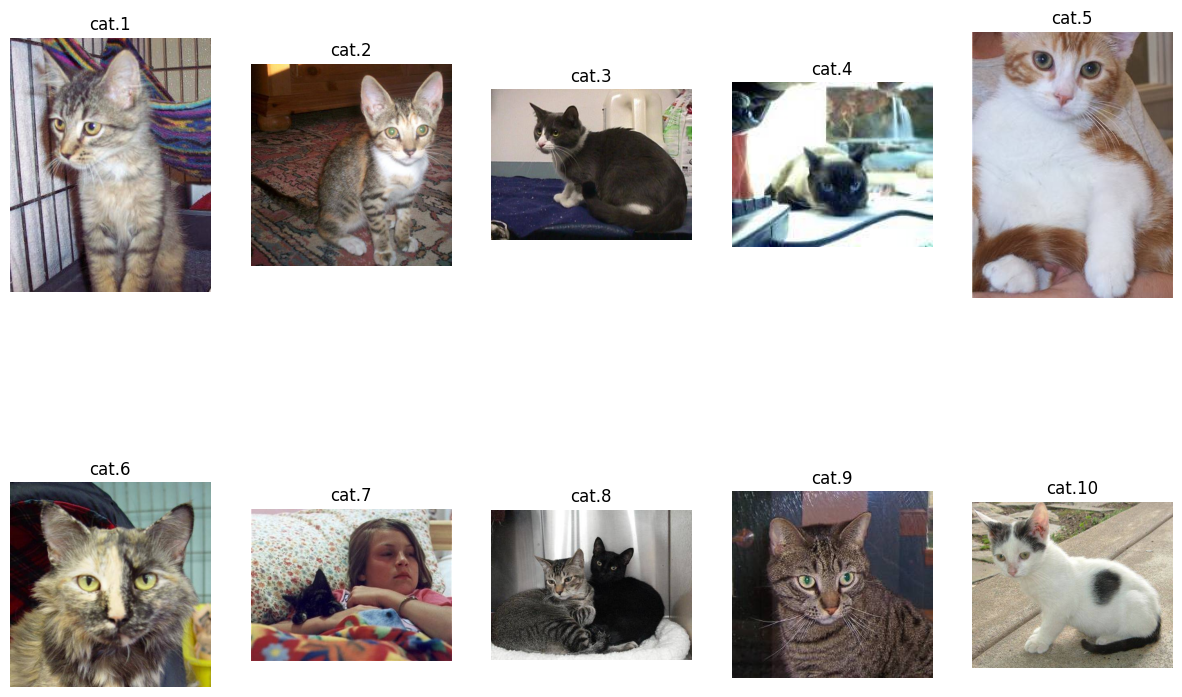

In [166]:
import os
import random

random.shuffle(images)
def plot_image(images, labels):
    num_images = len(images)
    plt.figure(figsize=(15, 10))
    for i in range(num_images): # tar in antalet bilder från len(images
        plt.subplot(2, 5, i+1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

labels = [os.path.splitext(os.path.basename(path))[0] for path in image_paths] #this extracts the filepath name<




# Plotta bilderna med deras etiketter som titlar
plot_image(images, labels)


## d) Nu ska du göra train|val|test split med följande splits
### experiment_small
* train - 1600 (800 dogs, 800 cats)
* val - 400 (200 dogs, 200 cats)
* test - 500 (250 dogs, 250 cats)
### experiment_tiny (BONUS)
* train - 160 (80 dogs, 80 cats)
* val - 40 (20 dogs, 20 cats)
* test - 50 (25 dogs, 25 cats)

## Preforming train|val|test

In [167]:
# dessa variabler kommer innehålla listan utav filerna för både hundar och katter
import random

train_destination_dir = Path().absolute() / "experiment_small_data/" / "train"
val_destination_dir = Path().absolute() / "experiment_small_data" / "val"
test_destination_dir = Path().absolute() / "experiment_small_data" / "test"


X_train_paths = list(train_destination_dir.glob("*"))

X_test_paths = list(test_destination_dir.glob("*"))

X_val_paths = list(val_destination_dir.glob("*"))


X_train_paths[-1].name[:3]  # få ut labelnamn

#Här shufflar vi listan en gång och behåller samma random för varje omkörning
random.seed(42)
random.shuffle(X_test_paths)
random.shuffle(X_train_paths)
random.shuffle(X_val_paths)

X_train_paths

y_train = np.array(
    [1 if pathname.name[:3] == "dog" else 0 for pathname in X_train_paths]
)  # listcomprehansion med if och else för namn

y_val = np.array(
    [1 if pathname.name[:3] == "dog" else 0 for pathname in X_val_paths]
)  # listcomprehansion med if och else för namn

y_test = np.array(
    [1 if pathname.name[:3] == "dog" else 0 for pathname in X_test_paths]
)  # listcomprehansion med if och else för namn



## Scaling

In [168]:
def load_and_preprocess_images(file_paths):
    images = []
    for file_path in file_paths:
        # Load image using OpenCV
        image = cv2.imread(str(file_path))
        # Convert image to float32 and scale to the range [0, 1]
        image = image.astype("float32") / 255
        images.append(image)
    return images

# Load and preprocess images in X_train and X_test
X_train = load_and_preprocess_images(X_train_paths)
X_test= load_and_preprocess_images(X_test_paths)
X_val = load_and_preprocess_images(X_val_paths)

# Check the minimum and maximum values after scaling
min_value_train = np.min([np.min(image) for image in X_train])
max_value_train = np.max([np.max(image) for image in X_train])
min_value_test = np.min([np.min(image) for image in X_test])
max_value_test = np.max([np.max(image) for image in X_test])

print("Minimum value in scaled X_train:", min_value_train)
print("Maximum value in scaled X_train:", max_value_train)
print("Minimum value in scaled X_test:", min_value_test)
print("Maximum value in scaled X_test:", max_value_test)

Minimum value in scaled X_train: 0.0
Maximum value in scaled X_train: 1.0
Minimum value in scaled X_test: 0.0
Maximum value in scaled X_test: 1.0


In [169]:
[X_train.shape for X_train in X_train][:5] #undersöker shape för alla

[(332, 499, 3), (264, 450, 3), (374, 500, 3), (338, 303, 3), (310, 500, 3)]

In [170]:
print(f"Original training data size: {len(X_train)}, {len(y_train)}")
print(f"Original testing data size: {len(X_test)}, {len(y_test)}")
print(f"Original validation data size: {len(X_val)}, {len(y_val)}")

Original training data size: 1600, 1600
Original testing data size: 500, 500
Original validation data size: 400, 400


# Resize

In [171]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_CHANNELS = 3

# funktion för att ändra storlek på test, val, train
def resize_image(image, height, width):
    return cv2.resize(image, (width, height))

X_train_resized = np.array([cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT)) for image in X_train])
X_test_resized = np.array([cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT)) for image in X_test])
X_val_resized = np.array([cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT)) for image in X_val])

# X_train_resized = np.array([resize_image(image, IMAGE_HEIGHT, IMAGE_WIDTH) for image in X_train])
# X_val_resized = np.array([resize_image(image, IMAGE_HEIGHT, IMAGE_WIDTH) for image in X_val])
# X_test_resized = np.array([resize_image(image, IMAGE_HEIGHT, IMAGE_WIDTH) for image in X_test])



   
# ändra X_train_resized till X_train igen?

In [172]:
[X_train.shape for X_train in X_train_resized][:5] #undersöker sizingen för alla images

[(128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3), (128, 128, 3)]

In [173]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

# resize


input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

# Define input layer
inputs = Input(shape=input_shape)

# Define the rest of the model
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs, outputs)


### Evaluating

In [174]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_533"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_528 (InputLayer)    │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2108 (Conv2D)            │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2098              │ (None, 63, 63, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2109 (Conv2D)            │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2099              │ (None, 30, 30, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2110 (Conv2D)            │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_528 (Flatten)           │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1054 (Dense)              │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1055 (Dense)              │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267,713 (12.47 MB)

 Trainable params: 3,267,713 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

In [175]:
len(X_train_resized)

1600

In [176]:
X_val_resized.shape

(400, 128, 128, 3)

In [177]:
print(np.min(X_train_resized), np.max(X_train_resized))


0.0 1.0


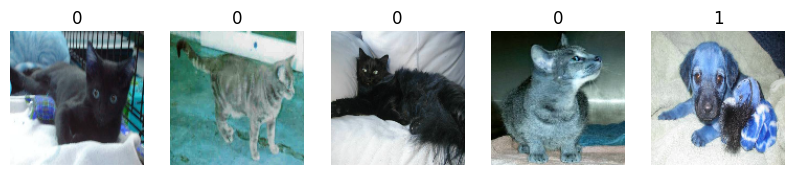

In [178]:
num_images = 5

plt.figure(figsize=(10, 5))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(X_train_resized[i])
    plt.axis('off')
    plt.title(f'{y_train[i]}')
plt.show()



# 1. Bildbehandling (*)
Uppgifterna nedan ska upprepas för respektive experimentdataset om du också väljer att arbeta med
tinydatasetet.
- a) Skapa en plot för att visualisera bildstorlekarna i träningsdatan. Använd seaborns jointplot.
- b) Välj en lämplig bildstorlek att ändra samtliga bilder till. Gör en analys och fundera på om du behöver
slänga bilder. Hur kommer du fram till ditt val?
- c) Gör resize sådant att samtliga bilder är samma storlek och spara dem i numpy arrays med följande
struktur

### 1a) Skapa en plot för att visualisera bildstorlekarna i träningsdatan. Använd seaborns jointplot.

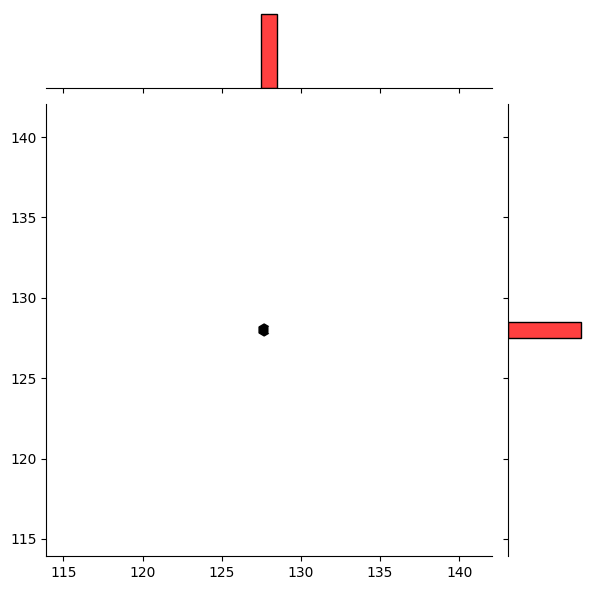

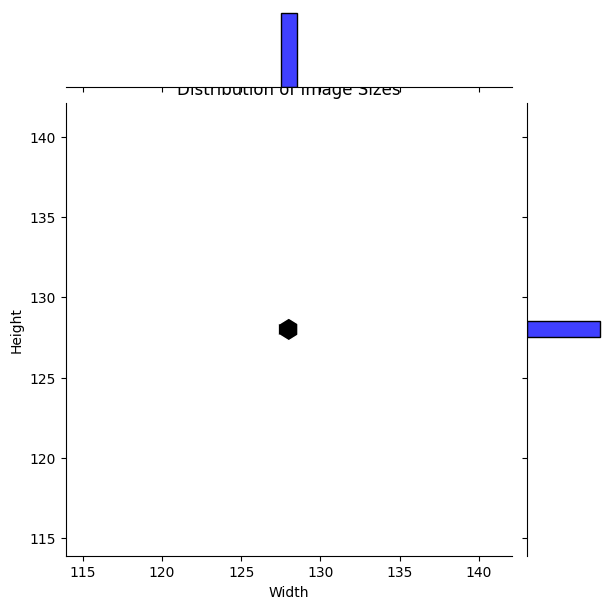

In [179]:
from seaborn import jointplot


#bara för bild 0 och 1
train_heights = [image.shape[0] for image in X_train_resized]
train_widths = [image.shape[1] for image in X_train_resized]
test_heights =[image.shape[0] for image in X_test_resized]
test_width =[image.shape[1] for image in X_test_resized]
# Create a jointplot
jointplot(x=train_widths, y=train_heights, kind='hex', color='red')
jointplot(x=test_heights, y=test_heights, kind='hex', color= 'blue')

# Set labels and title
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Distribution of Image Sizes')

# Show the plot
plt.show()

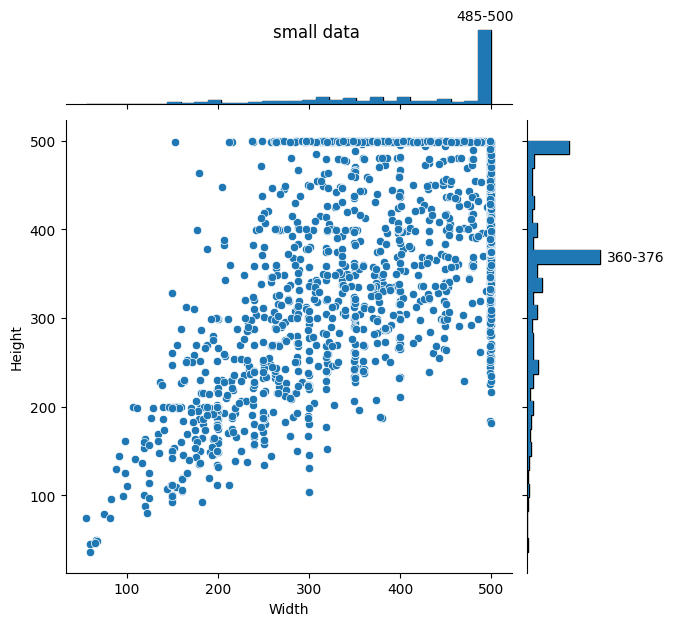

In [180]:
from pathlib import Path
from matplotlib.image import imread

def get_image_sizes(data_path):
    """Gather image dimensions for images in the specified directory."""
    sizes = []
    categories = ['train', 'val', 'test']
    for category in categories:
        cat_dir = data_path / category
        files = list(cat_dir.glob("*"))
        for image_path in files:
            img = imread(str(image_path))
            if len(img.shape) == 3:
                height, width, _ = img.shape
                sizes.append((width, height))
    return sizes

def plot_image_sizes(sizes, title):
    """Plot the image sizes using a jointplot and annotate the highest histogram bars with bin range."""
    widths, heights = zip(*sizes)
    widths = np.array(widths)
    heights = np.array(heights)

    # Create jointplot
    joint_plot = sns.jointplot(x=widths, y=heights, kind='scatter', marginal_kws=dict(bins=30, fill=True))
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.suptitle(title)

    # Annotate the highest bar in the x histogram
    n, bins, patches = joint_plot.ax_marg_x.hist(widths, bins=30, fill=True)
    max_idx = np.argmax(n)
    max_bin_start = bins[max_idx]
    max_bin_end = bins[max_idx + 1]
    joint_plot.ax_marg_x.annotate(f'{int(max_bin_start)}-{int(max_bin_end)}', xy=((max_bin_start + max_bin_end) / 2, max(n)), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

    # Annotate the highest bar in the y histogram
    n, bins, patches = joint_plot.ax_marg_y.hist(heights, bins=30, fill=True, orientation='horizontal')
    max_idx = np.argmax(n)
    max_bin_start = bins[max_idx]
    max_bin_end = bins[max_idx + 1]
    joint_plot.ax_marg_y.annotate(f'{int(max_bin_start)}-{int(max_bin_end)}', xy=(max(n), (max_bin_start + max_bin_end) / 2), xytext=(5, 0), textcoords='offset points', ha='left', va='center')

    plt.show()

# Setup paths
experiment_small_data = Path("experiment_small_data")


# Get sizes from each dataset
image_sizes_small = get_image_sizes(experiment_small_data)


# Generate plots with annotations
plot_image_sizes(image_sizes_small, "small data ")


### 1b) Välj en lämplig bildstorlek att ändra samtliga bilder till. Gör en analys och fundera på om du behöver slänga bilder. Hur kommer du fram till ditt val?

In [181]:

# redan gjort ^^^^ 128, 128, 3

### 1c) Gör resize sådant att samtliga bilder är samma storlek och spara dem i numpy arrays med följande struktur 

(samples, row, cols, color_channels)

# 2. Träna modeller (*)
För uppgifterna nedan, jobba med dataseten en åt gången:
### small 
- utan augmentering
- med augmentering
### tiny (BONUS)
- utan augmentering
- med augmentering
 

In [182]:
history = model.fit(X_train_resized, y_train, epochs=10, validation_data=(X_val_resized, y_val))

# Evaluating  on the validation data
val_loss, val_acc = model.evaluate(X_val_resized, y_val)
print("Validation Accuracy:", val_acc)

# Evaluering på test data
test_loss, test_acc = model.evaluate(X_test_resized, y_test)
print("Test Accuracy:", test_acc)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.4914 - loss: 0.7871 - val_accuracy: 0.5175 - val_loss: 0.6949
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.5923 - loss: 0.6692 - val_accuracy: 0.6825 - val_loss: 0.5982
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.6655 - loss: 0.6113 - val_accuracy: 0.6850 - val_loss: 0.5985
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.7357 - loss: 0.5360 - val_accuracy: 0.6700 - val_loss: 0.5891
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.7684 - loss: 0.4880 - val_accuracy: 0.6875 - val_loss: 0.5965
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.8079 - loss: 0.4278 - val_accuracy: 0.6825 - val_loss: 0.6201
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.8379 - loss: 0.3585 - val_accuracy: 0.6925 - val_loss: 0.6464
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.8664 - loss: 0.3165 - val_accuracy: 0.

###   a) Använd följande nätverk och träna på datan. Gör hyperparametertuning för några parametrar (beskrivhur du gör). Visualisera och analysera loss-kurvor, accuracy-kurvor.

In [183]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


early_stopper = EarlyStopping(monitor = "val_loss", mode="min", patience = 3, restore_best_weights=True)


def cnn_model(learning_rate = 0.001, dropout_rate = 0.5, kernels =[32,64,128]):
    adam = Adam(learning_rate = learning_rate)
    model = Sequential(name="CNN_model")

#skapar nätverket
    model = Sequential(
        [

           Conv2D(kernel_size=(3,3), filters=32, activation="relu", kernel_initializer= "he_normal", input_shape = (128,128,3)),
           MaxPooling2D(strides=(2,2), pool_size=(2,2)),
           Conv2D(kernel_size=(3,3), filters=64, activation="relu", kernel_initializer="he_normal"),
           MaxPooling2D(strides=(2,2), pool_size=(2,2)),
           Conv2D(kernel_size=(3,3), filters=128, activation="relu", kernel_initializer="he_normal"),
           MaxPooling2D(strides=(2,2), pool_size=(2,2)),
           Conv2D(kernel_size=(3,3), filters=128, activation="relu", kernel_initializer="he_normal"),
           MaxPooling2D(strides=(2,2), pool_size=(2,2)),
           Flatten(),
           Dropout(0.3),
           Dense(512, activation="relu"),
           Dense(1, activation="sigmoid")
    
        ]
    )

#gör till en funktion model = cnn_model()

    model.compile(loss="binary_crossentropy", optimizer = adam, metrics = ["acc"])
    model = cnn_model()
    model.summary()
    return model




In [184]:
history = model.fit(X_train_resized, y_train, epochs=10, validation_data=(X_val_resized, y_val))


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9703 - loss: 0.0934 - val_accuracy: 0.6575 - val_loss: 1.2401
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.9765 - loss: 0.0697 - val_accuracy: 0.6575 - val_loss: 1.4909
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.9887 - loss: 0.0418 - val_accuracy: 0.6600 - val_loss: 1.7252
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.9989 - loss: 0.0186 - val_accuracy: 0.6675 - val_loss: 1.9003
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9983 - loss: 0.0143 - val_accuracy: 0.6550 - val_loss: 1.9957
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.9999 - loss: 0.0049 - val_accuracy: 0.6925 - val_loss: 2.1832
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.6800 - val_loss: 2.2804
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.

In [199]:
import pandas as pd
metrics = pd.DataFrame(model.history.history)
metrics.rename(columns={'accuracy': 'acc', 'val_accuracy': 'val_acc'}, inplace=True)

metrics.head()

,acc,loss,val_acc,val_loss
0,0.967500,0.092985,0.6575,1.240076
1,0.976875,0.066652,0.6575,1.490895
2,0.988125,0.041907,0.6600,1.725187
3,0.998125,0.018238,0.6675,1.900309
4,0.998750,0.013794,0.6550,1.995691


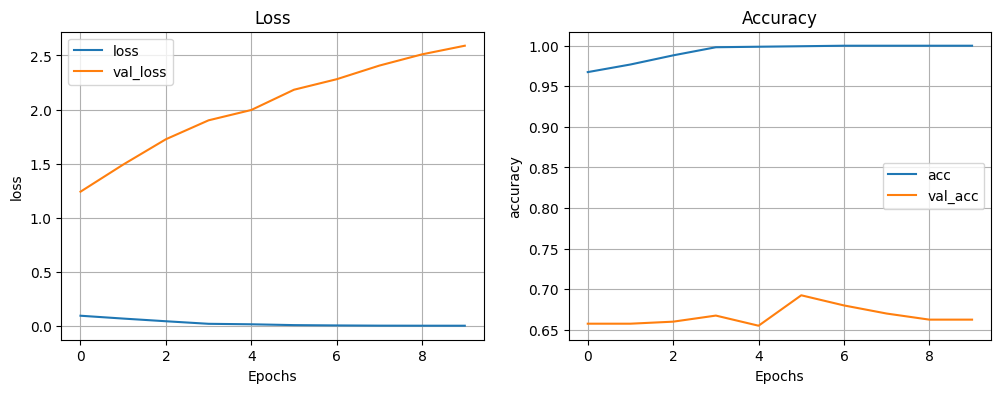

In [197]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True, xlabel = "Epochs", ylabel = "loss")
    metrics[["acc", "val_acc"]].plot(ax = ax[1], title = "Accuracy", grid = True, xlabel = "Epochs", ylabel = "accuracy")

plot_metrics(metrics) 

# har jag overfitting
# varför kan jag inte skapa ny model, behöver jag for kerknel in kernels?

In [201]:
model2 = cnn_model()
history2 = model2(X_train_resized, y_train, epochs=20, validation_data=(X_val_resized, y_val))
val_loss2, val_acc2 = model2.evaluate(X_val_resized, y_val)


KeyboardInterrupt: 